# Project: German Traffic Sign Recognition Benchmark
### Angel Alavarez. @Anggel7x

This project seeks to train a deep neural network to be able to recognize between 43 different images of German traffic signs.

### Datos

The dataset is discussed and analyzed previously in the <code>Data Processing.ipynb</code> notebook. For practical purposes, this project only works with the data <code>test_data.npz</code> and <code>train_data.npz</code>.

### Set the environment

We first perform the initialization of the Colab notebook's connection to Google Drive so that it is able to extract the data. In addition to the request for a GPU to mount the neural network.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/GTSRB_Project

/content/drive/MyDrive/GTSRB_Sign_Detection


In [ ]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.nn import relu, softmax
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam

import warnings
warnings.filterwarnings('ignore')


In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


### Data and class balance

First we extract the data from the file <code>train_data.npz</code>

In [ ]:
training_save_file = 'processed/training_data.npz'
test_save_file = 'processed/test_data.npz'

training_data = np.load(training_save_file)
X_train, Y_train  = training_data['X'], training_data['Y']
print(X_train.shape, Y_train.shape)

(39209, 4096) (39209, 1)


Now, the creation of the weights for the multiclassification cost function is carried out.

In [ ]:
counts = np.bincount(Y_train.reshape(-1)).astype(float)
inverses = np.reciprocal(counts)
weights = inverses / np.linalg.norm(inverses)

For the neural network to be able to predict classes, it is necessary to convert the classification integer values to 43-element vectors that correspond to only 1 in the enumeration of the class to which they belong.

In [ ]:
Y_probs = []

for y in Y_train:

    label = y[0]
    Y = np.zeros(43)
    Y[label] += 1
    Y_probs.append(Y)


The input data are normalized and both sets are mixed.

In [ ]:
X = X_train * 1/255.
Y = np.array(Y_probs)

In [ ]:
X, Y = shuffle(X, Y)

We create an exponential decay schedule for the relatively low learning rate. Every 10,000 steps we will decrease the initial learning rate by 1%, which is $1e-3$.

In [ ]:
initial_learning_rate = 1e-3
lr_schedule = ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.01,
    staircase=False)

Also, since we want to monitor the evolution of the F1 Score through the ages, a tensorflow Callback is built to take care of this.

In [ ]:
class F1History(Callback):

    def __init__(self, train):
        super(F1History, self).__init__()
        self.train = train

    def on_epoch_end(self, epoch, logs={}):

        X_train, y_train = self.train[0], self.train[1]
        y_pred = self.model.predict(X_train, verbose=0)
        y_pred[ y_pred >= 0.5] = 1
        y_pred[ y_pred < 0.5 ] = 0
        score = f1_score(y_train, y_pred, average='samples')       

        
        logs['F1 score train'] = np.round(score, 5)

We built the neural network architecture consisting of a 64x64 input layer, three dense layers: one of 256, 512 with a dropout of 0.05 and 256, all triggered by relu, and an output layer of 43 neurons with Softmax for the multiclass.

In [ ]:
model = Sequential([
    Dense(X.shape[1], activation=relu),
    Dense(256, activation=relu),
    Dense(512, activation=relu),
    Dropout(0.05),
    Dense(256, activation= relu),
    Dense(Y.shape[1], activation=softmax)
])

The chosen cost function is the Categorical Cross Entropy with the weights included for the class balance, a common strategy for this type of network. In addition to the Adam optimizer with the default betas, and the exponential decay of the learning rate already detailed.

In [ ]:
model.compile(
    loss='categorical_crossentropy', 
    loss_weights=weights, 
    metrics=['accuracy'],
    optimizer=Adam(learning_rate=lr_schedule))

We proceed to train the model for 10 epochs, a batch size corresponding to a mini batch of 32, and mixing each batch once more.

In [ ]:
history = model.fit(X, Y, epochs=10, verbose=1, batch_size=32, shuffle=True, callbacks=[F1History((X, Y))])

Epoch 1/10
1226/1226 [==============================] - 18s 13ms/step - loss: 0.2162 - accuracy: 0.5075 - F1 score train: 0.6245
Epoch 2/10
1226/1226 [==============================] - 12s 10ms/step - loss: 0.0761 - accuracy: 0.8196 - F1 score train: 0.8055
Epoch 3/10
1226/1226 [==============================] - 13s 10ms/step - loss: 0.0491 - accuracy: 0.8868 - F1 score train: 0.8709
Epoch 4/10
1226/1226 [==============================] - 12s 10ms/step - loss: 0.0369 - accuracy: 0.9172 - F1 score train: 0.9082
Epoch 5/10
1226/1226 [==============================] - 12s 10ms/step - loss: 0.0304 - accuracy: 0.9332 - F1 score train: 0.9197
Epoch 6/10
1226/1226 [==============================] - 12s 10ms/step - loss: 0.0269 - accuracy: 0.9417 - F1 score train: 0.9285
Epoch 7/10
1226/1226 [==============================] - 11s 9ms/step - loss: 0.0250 - accuracy: 0.9465 - F1 score train: 0.9352
Epoch 8/10
1226/1226 [==============================] - 12s 10ms/step - loss: 0.0237 - accuracy: 0

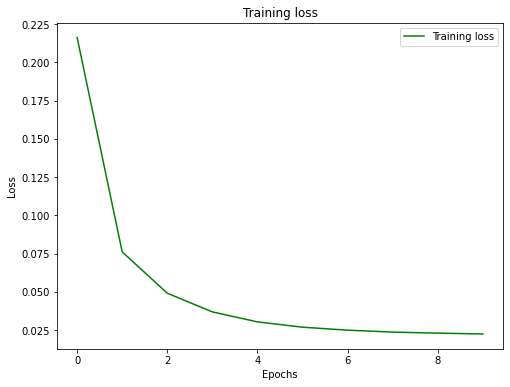

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(history.epoch, history.history["loss"], 'g', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

It can be seen that despite being only 10 epochs the model evolves appropriately. This speaks highly of the richness of the data set and the fineness of the chosen hyperparameters.

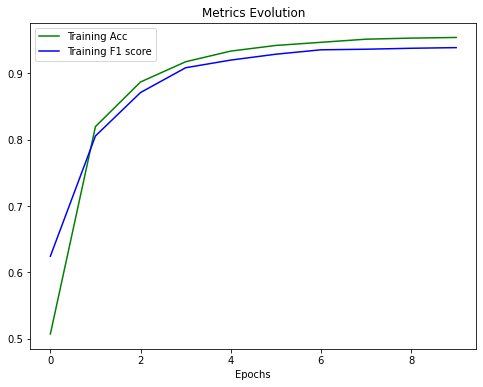

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(history.epoch, history.history["accuracy"], 'g', label='Training Acc')
plt.plot(history.epoch, history.history["F1 score train"], 'b', label='Training F1 score')
plt.xlabel('Epochs')
plt.title('Metrics Evolution')
plt.legend()
plt.show()

The idea that the network behaves very well in only 10 epochs is confirmed by this graph where the rapid rise of the accuracy and the F1 score of the network in the training data can be seen.

Now we evaluate the model

In [ ]:
test_data = np.load(test_save_file)
X_test, Y_test  = test_data['X'], test_data['Y']
print(X_test.shape, Y_test.shape)

(12629, 4096) (12629, 1)


In [ ]:
Y_probs_test = []

for y in Y_test:

    label = y[0]
    Y = np.zeros(43)
    Y[label] += 1
    Y_probs_test.append(Y)

In [ ]:
X_test, Y_probs_test  = shuffle(X_test * 1/255., np.array(Y_probs_test))
print(X_test.shape, Y_probs_test.shape)

(12629, 4096) (12629, 43)


In [ ]:
model.evaluate(X_test, Y_probs_test, verbose=1, callbacks=[F1History((X_test,Y_probs_test))])

395/395 [==============================] - 2s 4ms/step - loss: 0.0964 - accuracy: 0.8690


[0.09642559289932251, 0.8690316081047058]

In [ ]:
y_hat_test = model.predict(X_test, verbose=0)
y_hat_test[ y_hat_test >= 0.5] = 1
y_hat_test[ y_hat_test < 0.5] = 0
f1_score(Y_probs_test, y_hat_test, average='samples')

0.843693087338665

We see that the accuracy for the test set was 87% and the F1 Score 84%, quite high values for a network of this type.

We now proceed to perform a fairly simple test by selecting 5 random images from our test set and seeing what predictions the model gives us. In addition to seeing if it really corresponds to the real one.

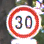

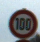

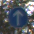

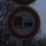

In [ ]:
X_cute_test = []
Y_cute_test = []
directory = 'simple test'
for filename in os.listdir(directory):
    num = int(filename[:-4])
    img = X_test[num]
    label =  Y_probs_test[num]
    display(Image.open(directory+'/'+filename))
    X_cute_test.append(img)
    Y_cute_test.append(label)

X_cute_test = np.array(X_cute_test)
Y_cute_test = np.array(Y_cute_test)

In [ ]:
y_predict_cute = model.predict(X_cute_test)

1/1 [==============================] - 0s 17ms/step


In [ ]:
predicted_labels = []
real_labels = []
for y_p, y_r  in zip(y_predict_cute, Y_cute_test):
  predicted_labels.append( np.where( y_p == 1)[0] )
  real_labels.append( np.where( y_r == 1)[0] )

In [ ]:
predicted_labels

[array([7]), array([25]), array([2]), array([35]), array([17])]

In [ ]:
real_labels

[array([7]), array([25]), array([2]), array([35]), array([17])]

For the 5 images it can be seen that all 5 were correctly classified. Thus, we conclude that the model is satisfactory and meets the requirements.